In [1]:
!pip install replicate
import replicate
import os

# Set token replicate
os.environ["REPLICATE_API_TOKEN"] = "r8_3L8dHtVJcI56j16Qb4NzyMV3bBzWq7p196OSc"


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.6/48.6 kB 3.4 MB/s eta 0:00:00


In [7]:
# Upload data (Colab)
from google.colab import files
uploaded = files.upload()

Saving Amazon Review Data Web Scrapping - Amazon Review Data Web Scrapping.csv to Amazon Review Data Web Scrapping - Amazon Review Data Web Scrapping.csv


In [8]:
# Simpan file
print("Uploaded:", list(uploaded.keys()))

Uploaded: ['Amazon Review Data Web Scrapping - Amazon Review Data Web Scrapping.csv']


In [9]:
import pandas as pd

# Baca data CSV
df = pd.read_csv("Amazon Review Data Web Scrapping - Amazon Review Data Web Scrapping.csv")

In [10]:
# Cek ukuran & kolom
print("Ukuran data:", df.shape)
print("Nama kolom:", list(df.columns))

Ukuran data: (60889, 6)
Nama kolom: ['Unique_ID', 'Category', 'Review_Header', 'Review_text', 'Rating', 'Own_Rating']


In [11]:
# Tampilkan 5 baris awal
df.head()

,Unique_ID,Category,Review_Header,Review_text,Rating,Own_Rating
0,136040,smartTv,Nice one,I liked it,5,Positive
1,134236,mobile,Huge battery life with amazing display,I bought the phone on Amazon and been using my...,5,Positive
2,113945,books,Four Stars,"Awesome book at reasonable price, must buy ......",4,Positive
3,168076,smartTv,Nice quality,good,5,Positive
4,157302,books,Nice book,"The book is fine,not bad,contains nice concept...",3,Neutral


In [38]:
# Memanngil 50 data sentimen
reviews = df["Review_text"].dropna().astype(str).sample(50, random_state=42).tolist()
reviews

['Very nice',
 'This product little problem as diceplay lite outomatic up and down Etc',
 "Just what we require today....it's a tech marvel.",
 'Used for about a month. Except for the night pics, overall performance is on par with flagship phones. Using a back cover will solve the issue of low quality back panel... I could achieve highest achieve screen-on-time of 10hrs 50mins which is by far the highest... with heavy use that could fall up to 9hrs 30mins... Dont believe about low audio quality (speaker)... Its good enough and while using headphones use Dolby atmos facility to enjoy premium sound.',
 'Nice book but pages are rough',
 'DAYLIGHT PHOTOGRAPHY IS EXCELLENT, NIGHT/ IN LOW LIGHT IT IS VERY BAD BATTERY IS EXCELLENT..',
 'For a long back I was looking for a complete mobile in affordable segment. M20 gave me this opportunity. After using for more than two months I am happy to purchase this one. Be it battery, screen, camera, fingerprint sensor, charging time, ram or rom everythi

In [30]:
# Menyimpan fungsi klasifikasi dengan Granite
import replicate

def classify_with_granite(text):
    prompt = f"""
    Klasifikasikan review berikut ke dalam kategori:
    1. Positif
    2. Netral
    3. Negatif

    Review_text: "{text}"
    Jawab hanya dengan satu label: Positif, Netral, atau Negatif.
    """
    out = replicate.run(
        "ibm-granite/granite-3.3-8b-instruct",
        input={"prompt": prompt, "max_new_tokens": 5}
    )
    return "".join(out).strip()

In [32]:
# Klasifikasi batch review menggunakan granite
import time

results = []
for r in reviews:
    try:
        label = classify_with_granite(r)
    except Exception as e:
        label = f"ERROR: {e}"
    results.append((r, label))
    time.sleep(1)

df_results = pd.DataFrame(results, columns=["Review_text", "Sentimen"])
print(df_results)

                                          Review_text Sentimen
0                                           Very nice  Positif
1   This product little problem as diceplay lite o...  Negatif
2   Just what we require today....it's a tech marvel.  Positif
3   Used for about a month. Except for the night p...  Positif
4                       Nice book but pages are rough  Positif
5   DAYLIGHT PHOTOGRAPHY IS EXCELLENT, NIGHT/ IN L...  Positif
6   For a long back I was looking for a complete m...  Positif
7   everything is perfect but the speakers make a ...  Negatif
8   Don't buy this better go for boat or some othe...  Negatif
9                                             It's ok   Netral
10                                           Not good  Negatif
11   Beautiful superb sound best product beat service  Positif
12  It's been just less than a year I bought iPhon...  Negatif
13  Good power bank, best for travelling purposes....  Positif
14  Installation is. Very big problem forMI tv sid...  

In [33]:
# Analisis distribusi sentimen
print(df_results["Sentimen"].value_counts())

Sentimen
Positif    29
Negatif    19
Netral      2
Name: count, dtype: int64


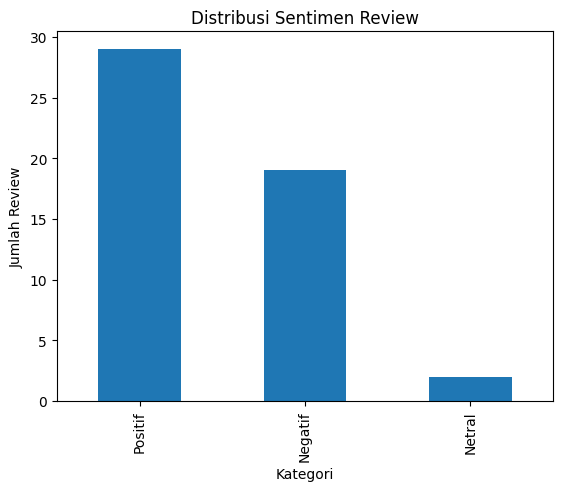

In [35]:
# Visualisasi distribusi sentimen
import matplotlib.pyplot as plt

df_results["Sentimen"].value_counts().plot(kind="bar")
plt.title("Distribusi Sentimen Review")
plt.xlabel("Kategori")
plt.ylabel("Jumlah Review")
plt.show()

Sentimen            Negatif  Netral  Positif
Category                                    
books                   1.0     0.0    166.0
mobile                 25.0     4.0   1109.0
mobile accessories     19.0     3.0    671.0
refrigerator            5.0     2.0    197.0
smartTv                 9.0     4.0    665.0


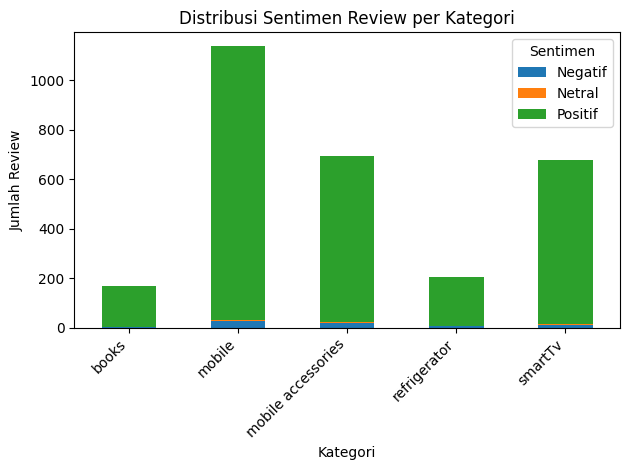

In [41]:
# Merge the sentiment results back to the original dataframe
df_merged = pd.merge(df, df_results, on="Review_text", how="inner")

# Analyze & visualize sentimen per kategori
sentimen_per_kategori = df_merged.groupby("Category")["Sentimen"].value_counts().unstack().fillna(0)
print(sentimen_per_kategori)

# Visualisasi distribusi sentimen per kategori
sentimen_per_kategori.plot(kind="bar", stacked=True)
plt.title("Distribusi Sentimen Review per Kategori")
plt.xlabel("Kategori")
plt.ylabel("Jumlah Review")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

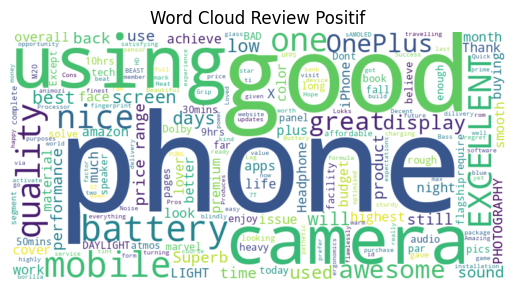

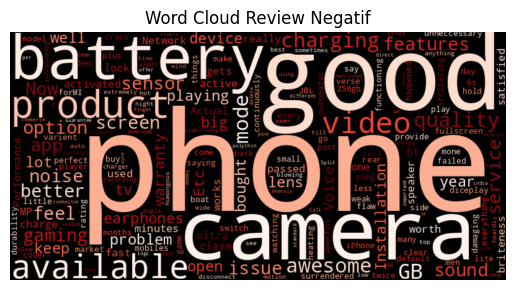

In [43]:
# Word cloud
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# word cloud positif
text_pos = " ".join(df_results[df_results["Sentimen"]=="Positif"]["Review_text"])
wc_pos = WordCloud(width=800, height=400, background_color="white").generate(text_pos)

plt.imshow(wc_pos, interpolation="bilinear")
plt.axis("off")
plt.title("Word Cloud Review Positif")
plt.show()

# word cloud negatif
text_neg = " ".join(df_results[df_results["Sentimen"]=="Negatif"]["Review_text"])
wc_neg = WordCloud(width=800, height=400, background_color="black", colormap="Reds").generate(text_neg)

plt.imshow(wc_neg, interpolation="bilinear")
plt.axis("off")
plt.title("Word Cloud Review Negatif")
plt.show()

In [47]:
# Analisis panjang review dengan sentimen
df_results["Review_length"] = df_results["Review_text"].apply(len)
df_results.groupby("Sentimen")["Review_length"].mean()

,Review_length
Sentimen,
Negatif,219.526316
Netral,7.000000
Positif,119.862069


Sentimen  Negatif  Netral  Positif
Rating                            
1              31       0       14
2              13       0       13
3               8       6      128
4               2       5      764
5               5       2     1889


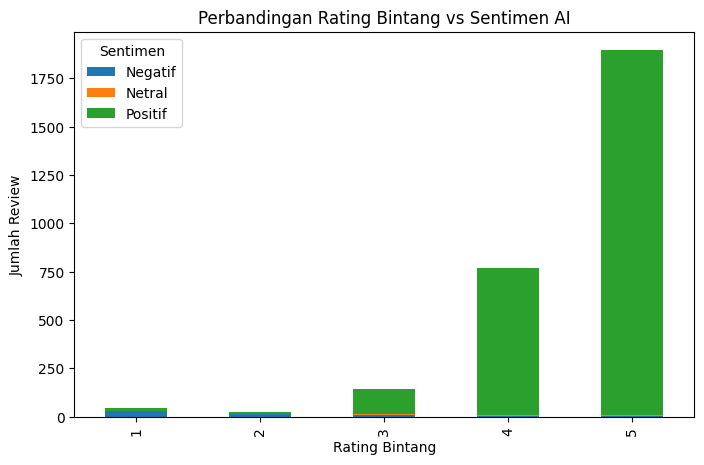

In [52]:
# Analisis rating vs sentimen
if "Rating" in df_merged.columns:
    cross_tab = pd.crosstab(df_merged["Rating"], df_merged["Sentimen"])
    print(cross_tab)

    cross_tab.plot(kind="bar", stacked=True, figsize=(8,5))
    plt.title("Perbandingan Rating Bintang vs Sentimen AI")
    plt.xlabel("Rating Bintang")
    plt.ylabel("Jumlah Review")
    plt.show()

In [50]:
# Simpan file dalam csv
df_results.to_csv("hasil_sentimen.csv", index=False)